# Analysis of the ensemble of models (1000 diverse Boolean networks)
  
    
## Table of content:
* [**Do the models fall into several groups based on their similarity?**](#clusters)
    + [MDS](#mds)
    + [Agglomerative hierarchical clustering](#aggclust)
* [Analysis of the clusters](#analysis)
    + [**Within each cluster, what is the number of functions for each node?**](#fctnb)
    + [**Complexity of the models' functions within each cluster?**](#fctcomplexity)
    + [**Complexity of the invariable functions within each cluster?**](#fctinvcomplexity)
    + [**Complexity of the clauses within the models' functions for each cluster?**](#clausecomplexity)
    + [**Statistics on each cluster**](#stat)

In [1]:
import mpbn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
modelname = []
modelname.extend([f"models/bn{n}.bnet" for n in range(1000)])

solutions = list()
for i,n in enumerate(modelname):
    solutions.append(mpbn.MPBooleanNetwork(f"{n}"))

`clauses_per_model` : list of models, each model being a dictionary
* keys = **model's nodes** 
* value = a set (-> **the clauses constituting the node's function in the model**)

In [3]:
# For each model, I store the clauses per node
clauses_per_model = list() #Each element of this list will correspond to a model, it's a dict linking nodes and their clauses.
for i, model in enumerate(solutions): #We go through the 1000 models.
    clauses_of_a_node = dict() #The dict that will link a node to its clauses.
    for node in model.keys(): #We go through the nodes of the model.
        #if not isinstance(model[node],frozenset):
        if model[node]==True or model[node]==False :
            clauses_of_a_node[node] = model[node]
        else:
            clauses_of_a_node[node] = mpbn.minibn.struct_of_dnf(model.ba, model[node]) #We store the clauses ruling this node.
    clauses_per_model.append(clauses_of_a_node) #Now that all nodes are linked with their clauses, we save this information as a new element in clauses_per_model.

`influences` : dictionnary
* keys = **model's nodes** 
* value = dictionary  
     + keys = **its inhibitors and activators**
     + value = **number of models having this inhibitor/activator in the node's function**

`constantes` : dictionnary
* keys = **model's nodes with at least one constant function in a model (constant function : 1 or 0)**
* value = dictionnary
     + key = **value of the constant function (TRUE for 1, FALSE for 0)**
     + value = **number of models having 1 or 0 as function for the node**

In [4]:
influences = dict()
constantes = dict()
for model in clauses_per_model:
    for node, influenceurs_set in model.items():
        temp = set()
        if node not in influences:
            influences[node] = dict()
        #print(influenceurs_set)
        #print(type(influenceurs_set))
        #print(isinstance(influenceurs_set, bool))
        if influenceurs_set != True and influenceurs_set != False:
            for conjonctions in influenceurs_set:
                for clause in conjonctions:
                    if clause[0] not in temp:
                        temp.add(clause[0])
                        if clause[0] not in influences[node]:
                            influences[node][clause[0]] = dict()
                            influences[node][clause[0]][clause[1]] = 1
                        elif clause[1] not in influences[node][clause[0]]:
                            influences[node][clause[0]][clause[1]] = 1
                        else:
                            influences[node][clause[0]][clause[1]] += 1
        else:
            if node not in constantes:
                constantes[node] = dict()
            if influenceurs_set not in constantes[node]:
                constantes[node][influenceurs_set] = 1
            else:
                constantes[node][influenceurs_set] += 1

## Clusters among the ensemble of models ? <a class="anchor" id="clusters"></a>

Use of 2 methods:
* MDS (MultiDimensional Scaling)
* agglomerative hierarchical clustering

In order to use these methods, it was necessary to determine a distance metric between the models. This "inter-BN" distance is the following:  
**Given $m_1$ and $m_2$ two Boolean networks of dimension $n$,  
the distance "inter-BN" $d(m_1,m_2) = \sum_{i=1}^{n} \mathbb{1}(m_{1}[i] \neq m_{2}[i])$**

Depending on the random seed used for the MDS, we get 3 or 4 clusters. Among them, 2 clusters are always strictly identical. For the following ones, two scenarios depending on whether there are 3 or 4 clusters in total:

* **In the case of the division into 4 clusters,** the division between the 2 remaining groups is unstable depending on the random seed used for the calculation. For example:
   - **4+1 :** $[0, 93, 675, 966]$ et $[1]$
   - **3+2 :** $[93, 675, 966]$ et $[0, 1]$
* **In the case of the division into 3 clusters,** the clusters remain identical regardless of the random seeds tested. Cluster 3 being :
   - $[0, 1, 93, 675, 966]$


Hierarchical 3-cluster clustering results in exactly the same 3 clusters as 3-cluster MDS. Hierarchical clustering into 4 clusters leads to the following division:
* $[0, 1, 93, 966]$ et $[675]$

Given the consistency of the division into 3 clusters, this clustering appears to be the most relevant.

In [5]:
# packages pour calculer MDS et AgglomerativeClustering + scatterplot et dendrogram
import sklearn as sk
from sklearn import manifold
from sklearn import cluster
import sklearn.datasets as dt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

In [6]:
df_models = pd.DataFrame(clauses_per_model)

### Creation of the distance matrix

In [ ]:
dissimilarity_matrix = np.zeros((1000,1000))

for i in range(0,1000):
    for j in range(i+1,1000):
        distance = 0
        for node in influences.keys():
            if df_models.loc[i,node] != df_models.loc[j,node]:
                distance += 1
        dissimilarity_matrix[i,j] = distance
        dissimilarity_matrix[j,i] = distance

If needed:

In [ ]:
# saving the similarity matrix:
import pickle
with open('data/analysis/clusters/dissimilarity_matrix_1000.binary', 'wb') as f:
    pickle.dump(dissimilarity_matrix, f)

In [7]:
# recovery of the similarity matrix:
import pickle
with open('data/analysis/clusters/dissimilarity_matrix_1000.binary', 'rb') as f:
    dissimilarity_matrix = pickle.load(f)

### MDS <a class="anchor" id="mds"></a>

In [ ]:
# To display the figures outside the notebook :
%matplotlib qt

#### MDS 2D

**Large majority of random seeds: 3 clusters.**  
Example here with seed 10:

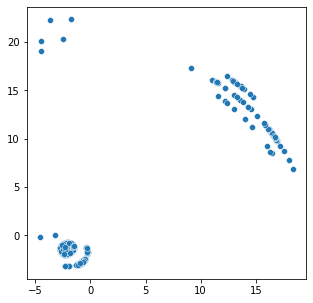

In [8]:
mds = manifold.MDS(
    dissimilarity="precomputed", 
    random_state=10 #3 pour 250
)
npos = mds.fit_transform(dissimilarity_matrix)

f = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=npos[:, 0], y=npos[:, 1])

**Seeds resulting in 4 clusters constantly split the same cluster, but in an unstable way (it is not constantly the same models which are separated).**  
Example here with seed 12:

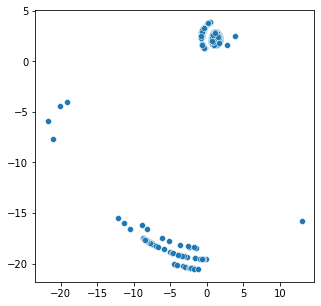

In [15]:
mds_4c = manifold.MDS(
    dissimilarity="precomputed", 
    random_state=12  #,n_jobs=-1 : pour calculer en utilisant tous les cœurs.
) 
npos_4c = mds_4c.fit_transform(dissimilarity_matrix)

f = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=npos_4c[:, 0], y=npos_4c[:, 1])

#### MDS 3D
Does not allow to refine the clustering compared to 2D.

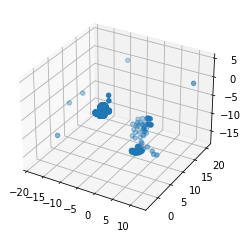

In [11]:
mds_3D = manifold.MDS(
    n_components=3,
    dissimilarity="precomputed"
)
npos_3D = mds_3D.fit_transform(dissimilarity_matrix)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs = npos_3D[:, 0]
ys = npos_3D[:, 1]
zs = npos_3D[:, 2]
ax.scatter(xs, ys, zs)

#### Analysis of MDS 2D, 3 clusters (random seed n°10):

Position of the different clusters in the 2D graph:
* $y < 2$
* $x < 0, y > 15$
* $x > 5$

##### 1) Plot : highlighting clusters with different colors.

In [9]:
# Je crée un vecteur de booléen pour savoir si le modèle i est dans le cluster0 ou non.
cluster0_x = npos[:,0] < 0
cluster0_y = npos[:,1] > 15
cluster0 = cluster0_x & cluster0_y

cluster0_indices = list()
for i in range(0,npos.shape[0]):
    if cluster0[i]:
        cluster0_indices.append(i)
len(cluster0_indices)

5

In [ ]:
cluster0_indices

In [10]:
# Je crée un vecteur de booléen pour savoir si le modèle i est dans le cluster1 ou non.
cluster1 = npos[:,1] < 2

cluster1_indices = list()
for i in range(0,npos.shape[0]):
    if cluster1[i]:
        cluster1_indices.append(i)
len(cluster1_indices)

885

In [ ]:
cluster1_indices

In [11]:
# Je crée un vecteur de booléen pour savoir si le modèle i est dans le cluster2 ou non.
cluster2 = npos[:,0] > 5

cluster2_indices = list()
for i in range(0,npos.shape[0]):
    if cluster2[i]:
        cluster2_indices.append(i)
len(cluster2_indices)

110

In [ ]:
cluster2_indices

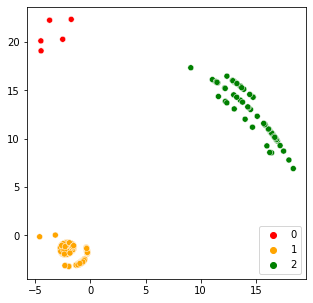

In [12]:
# Scatterplot coloré par cluster :

categories = list()
for i in range(0,1000):
    if cluster0[i]:
        categories.append(0)
    elif cluster1[i]:
        categories.append(1)
    elif cluster2[i]:
        categories.append(2)

correspondance_couleur = {0:'red', 1:'orange', 2:'green'}

f = plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x=npos[:, 0], y=npos[:, 1], hue=categories, palette=correspondance_couleur)
plt.legend(loc='lower right')

#### Agglomerative hierarchical clustering <a class="anchor" id="aggclust"></a>

In [13]:
clustering = cluster.AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average", compute_distances=True).fit(dissimilarity_matrix)

Are there differences between the clustering in 3 groups obtained by the MDS and by the aggl. clustering? To do this, search for a bijection:

In [14]:
dist_clusterings = 0
for i in range(0,1000):
    if clustering.labels_[i] != categories[i]:
        dist_clusterings += 1
        print(f"{i}eme BN: {categories[i]} vs {clustering.labels_[i]}")
print(f"{dist_clusterings} differences between the clustering obtained by MDS and that obtained by AggClust.")

0 differences between the clustering obtained by MDS and that obtained by AggClust.


In [15]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

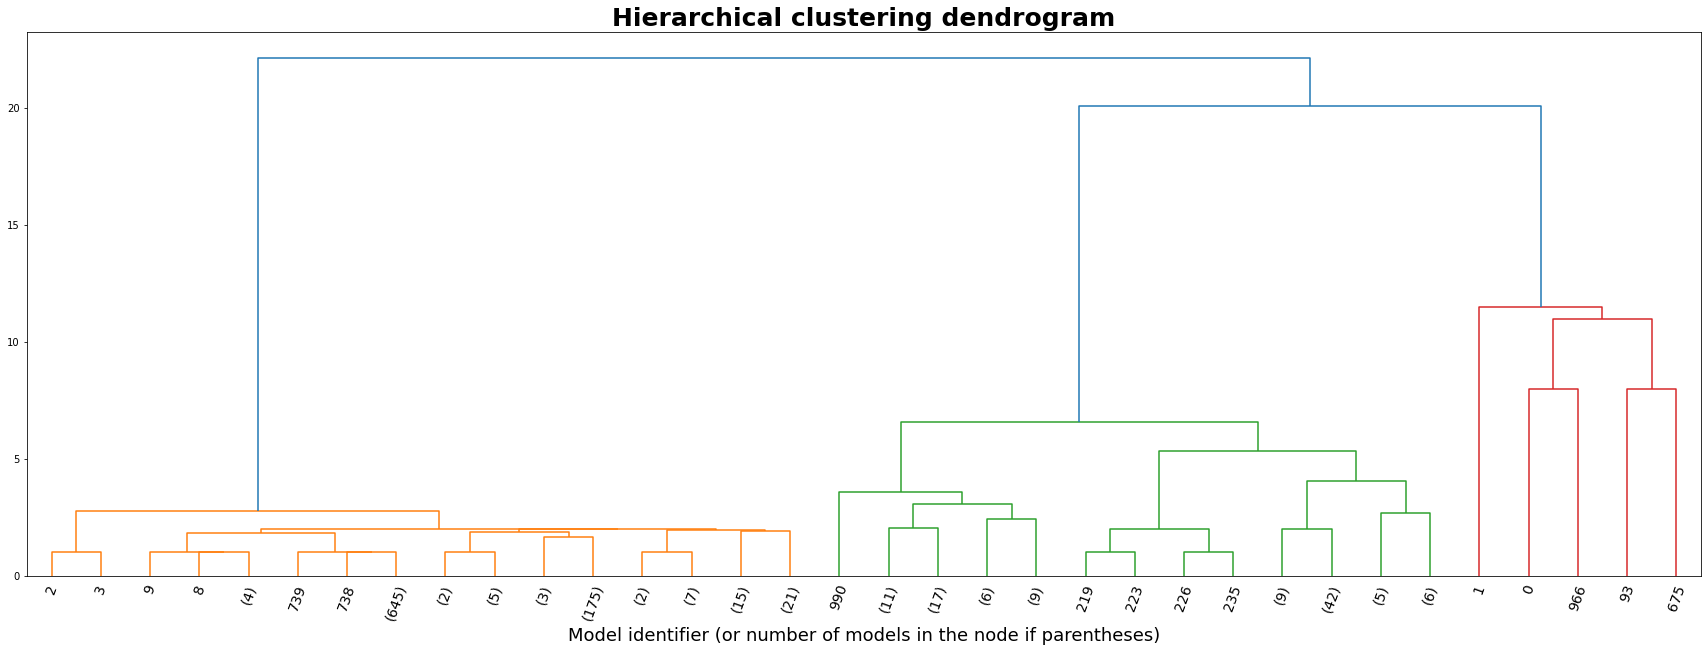

In [16]:
f = plt.figure(figsize=(30, 10))
plt.title("Hierarchical clustering dendrogram", fontsize=25, weight='bold')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode="level", p=5, leaf_font_size=14, leaf_rotation=70)
plt.xlabel("Model identifier (or number of models in the node if parentheses)", fontsize=18)
plt.show()

## Clusters analysis : compare functions within clusters. <a class="anchor" id="analysis"></a>

In [17]:
cluster_red = cluster0_indices
cluster_orange = cluster1_indices
cluster_green = cluster2_indices

### Within each cluster, what is the number of functions for each node? <a class="anchor" id="fctnb"></a>

In [19]:
# Required : influences
nodes_of_the_model = influences.keys()

In [20]:
def count_nb_of_clauses_of_a_function(function):
    return len(function) if (function != True and function != False) else 1

In [22]:
def count_nb_of_components_into_successive_clauses_of_a_function(function):
    nb_components_in_clause = list()
    
    if (function != True and function != False):
        for clause in function:
            nb_components_in_clause.append(len(clause))
    else:
        nb_components_in_clause.append(1)
        
    return nb_components_in_clause

In [23]:
def count_nb_of_functions_per_node_per_cluster(cluster):
    # Required :
    # - nodes_of_the_model
    # - clauses_per_model
    # - count_nb_of_clauses_of_a_function(function)
    
    #Outputs:
    nbOfFunctionsPerNode = dict()
    nbOfFunctions = list()
    uniqueFunctionNode = dict()
    nbOfClausesOfUniqueFunctionNode = list()
    nbOfClausesOfEachFunction = list()
    nbOfComponentsInClause = list()
    #Pour stocker les fonctions différentes pour un même nœud, pendant le parcours des BN d'un même cluster:
    functionsOfANode = set()
    
    for gene in nodes_of_the_model:
        
        #Parcours des BN du cluster, pour collecter au sein d'un set l'ensemble des fonctions possibles pour gene:
        for i in cluster:
            functionsOfANode.add(clauses_per_model[i][gene])
            #liste qui va recueillir le nombre de clauses de chaque fonction de chaque nœud de chaque gène de chaque modèle du cluster:
            #(tous à la suite, sans autre information, simplement pour stats nb de fois qu'on a 1/2/3... clauses dans les fonctions des modèles au sein du cluster)
            nbOfClausesOfEachFunction.append(count_nb_of_clauses_of_a_function(clauses_per_model[i][gene]))
            nbOfComponentsInClause.extend(count_nb_of_components_into_successive_clauses_of_a_function(clauses_per_model[i][gene]))
        #Le nombre de fonctions pour gene au sein du cluster est stocké dans une liste,
        #afin de pouvoir ensuite faire des stats sur le nb de genes ayant i fonctions possibles:
        nbOfFunctions.append(len(functionsOfANode))
        #Et afin de lier gene à son nb de fonctions:
        nbOfFunctionsPerNode[gene] = len(functionsOfANode)
        
        #Pour chaque gene ayant spécifiquement qu'une seule fonction:
        if len(functionsOfANode) == 1:
            #comptage du nb de clauses de cette fonction:
            nbOfClauses = count_nb_of_clauses_of_a_function(clauses_per_model[i][gene])
            #afin de pouvoir ensuite faire des stats sur le nb de fonctions constantes ayant i clauses:
            nbOfClausesOfUniqueFunctionNode.append(nbOfClauses)
            #et afin de lier le gene concerné au nb de clauses de son unique fonction:
            uniqueFunctionNode[gene] = nbOfClauses
        
        ##Pour visualiser, si besoin, les fonctions de chaque gene:
        #print(f"{gene}: {len(functionsOfANode)} functions")
        #for f in functionsOfANode:
        #    print(f">> {f}")
        #print("\n")
        
        #Réinitialisation du set avant le parcours des BN pour le gene suivant:
        functionsOfANode = set()  
        
    return nbOfFunctionsPerNode, nbOfFunctions, uniqueFunctionNode, nbOfClausesOfUniqueFunctionNode, nbOfClausesOfEachFunction, nbOfComponentsInClause

In [25]:
nbOfFunctionsPerNode_red, nbOfFunctions_red, uniqueFunctionNode_red, nbOfClausesOfUniqueFunctionNode_red, nbOfClauses_red, nbOfComponentsInClause_red = count_nb_of_functions_per_node_per_cluster(cluster_red)
nbOfFunctionsPerNode_orange, nbOfFunctions_orange, uniqueFunctionNode_orange, nbOfClausesOfUniqueFunctionNode_orange, nbOfClauses_orange, nbOfComponentsInClause_orange = count_nb_of_functions_per_node_per_cluster(cluster_orange)
nbOfFunctionsPerNode_green, nbOfFunctions_green, uniqueFunctionNode_green, nbOfClausesOfUniqueFunctionNode_green, nbOfClauses_green, nbOfComponentsInClause_green = count_nb_of_functions_per_node_per_cluster(cluster_green)

In [26]:
print("Number of nodes with the same function in all models of the cluster :")
print(f"Red: {len(uniqueFunctionNode_red.keys())}/{len(influences.keys())}")
print(f"Orange: {len(uniqueFunctionNode_orange.keys())}/{len(influences.keys())}")
print(f"Green: {len(uniqueFunctionNode_green.keys())}/{len(influences.keys())}")

Number of nodes with the same function in all models of the cluster :
Red: 23/39
Orange: 35/39
Green: 27/39


### Complexity of the models' functions within each cluster? <a class="anchor" id="fctcomplexity"></a>
"Function complexity" in the sense of having a lot of clauses.

**Construction of a barplot of the percentage of functions of the cluster's models having x clauses:**

In [27]:
# The barplot idea: show how many functions of the cluster models consist of x clauses
def create_barplot_vectors_nb_functions_per_nb_clauses(nbOfClauses):
    nbOfClauses_node = list()
    nbOfFunctions_node = list()
    for i in range(min(nbOfClauses), max(nbOfClauses)+1):
        nbOfClauses_node.append(i)
        nbOfFunctions_node.append(nbOfClauses.count(i))
    return np.array(nbOfClauses_node), np.array(nbOfFunctions_node)/sum(nbOfFunctions_node)*100, np.array(nbOfFunctions_node)

In [28]:
nbOfClauses_barplot_red, nbOfFunctionsPercentage_barplot_red, nbOfFunctions_barplot_red = create_barplot_vectors_nb_functions_per_nb_clauses(nbOfClauses_red)
nbOfClauses_barplot_orange, nbOfFunctionsPercentage_barplot_orange, nbOfFunctions_barplot_orange = create_barplot_vectors_nb_functions_per_nb_clauses(nbOfClauses_orange)
nbOfClauses_barplot_green, nbOfFunctionsPercentage_barplot_green, nbOfFunctions_barplot_green = create_barplot_vectors_nb_functions_per_nb_clauses(nbOfClauses_green)

Creation of a barplot with the 3 data series:

Text(0, 0.5, 'Percentage of functions out of all those \n belonging to models of the same group')

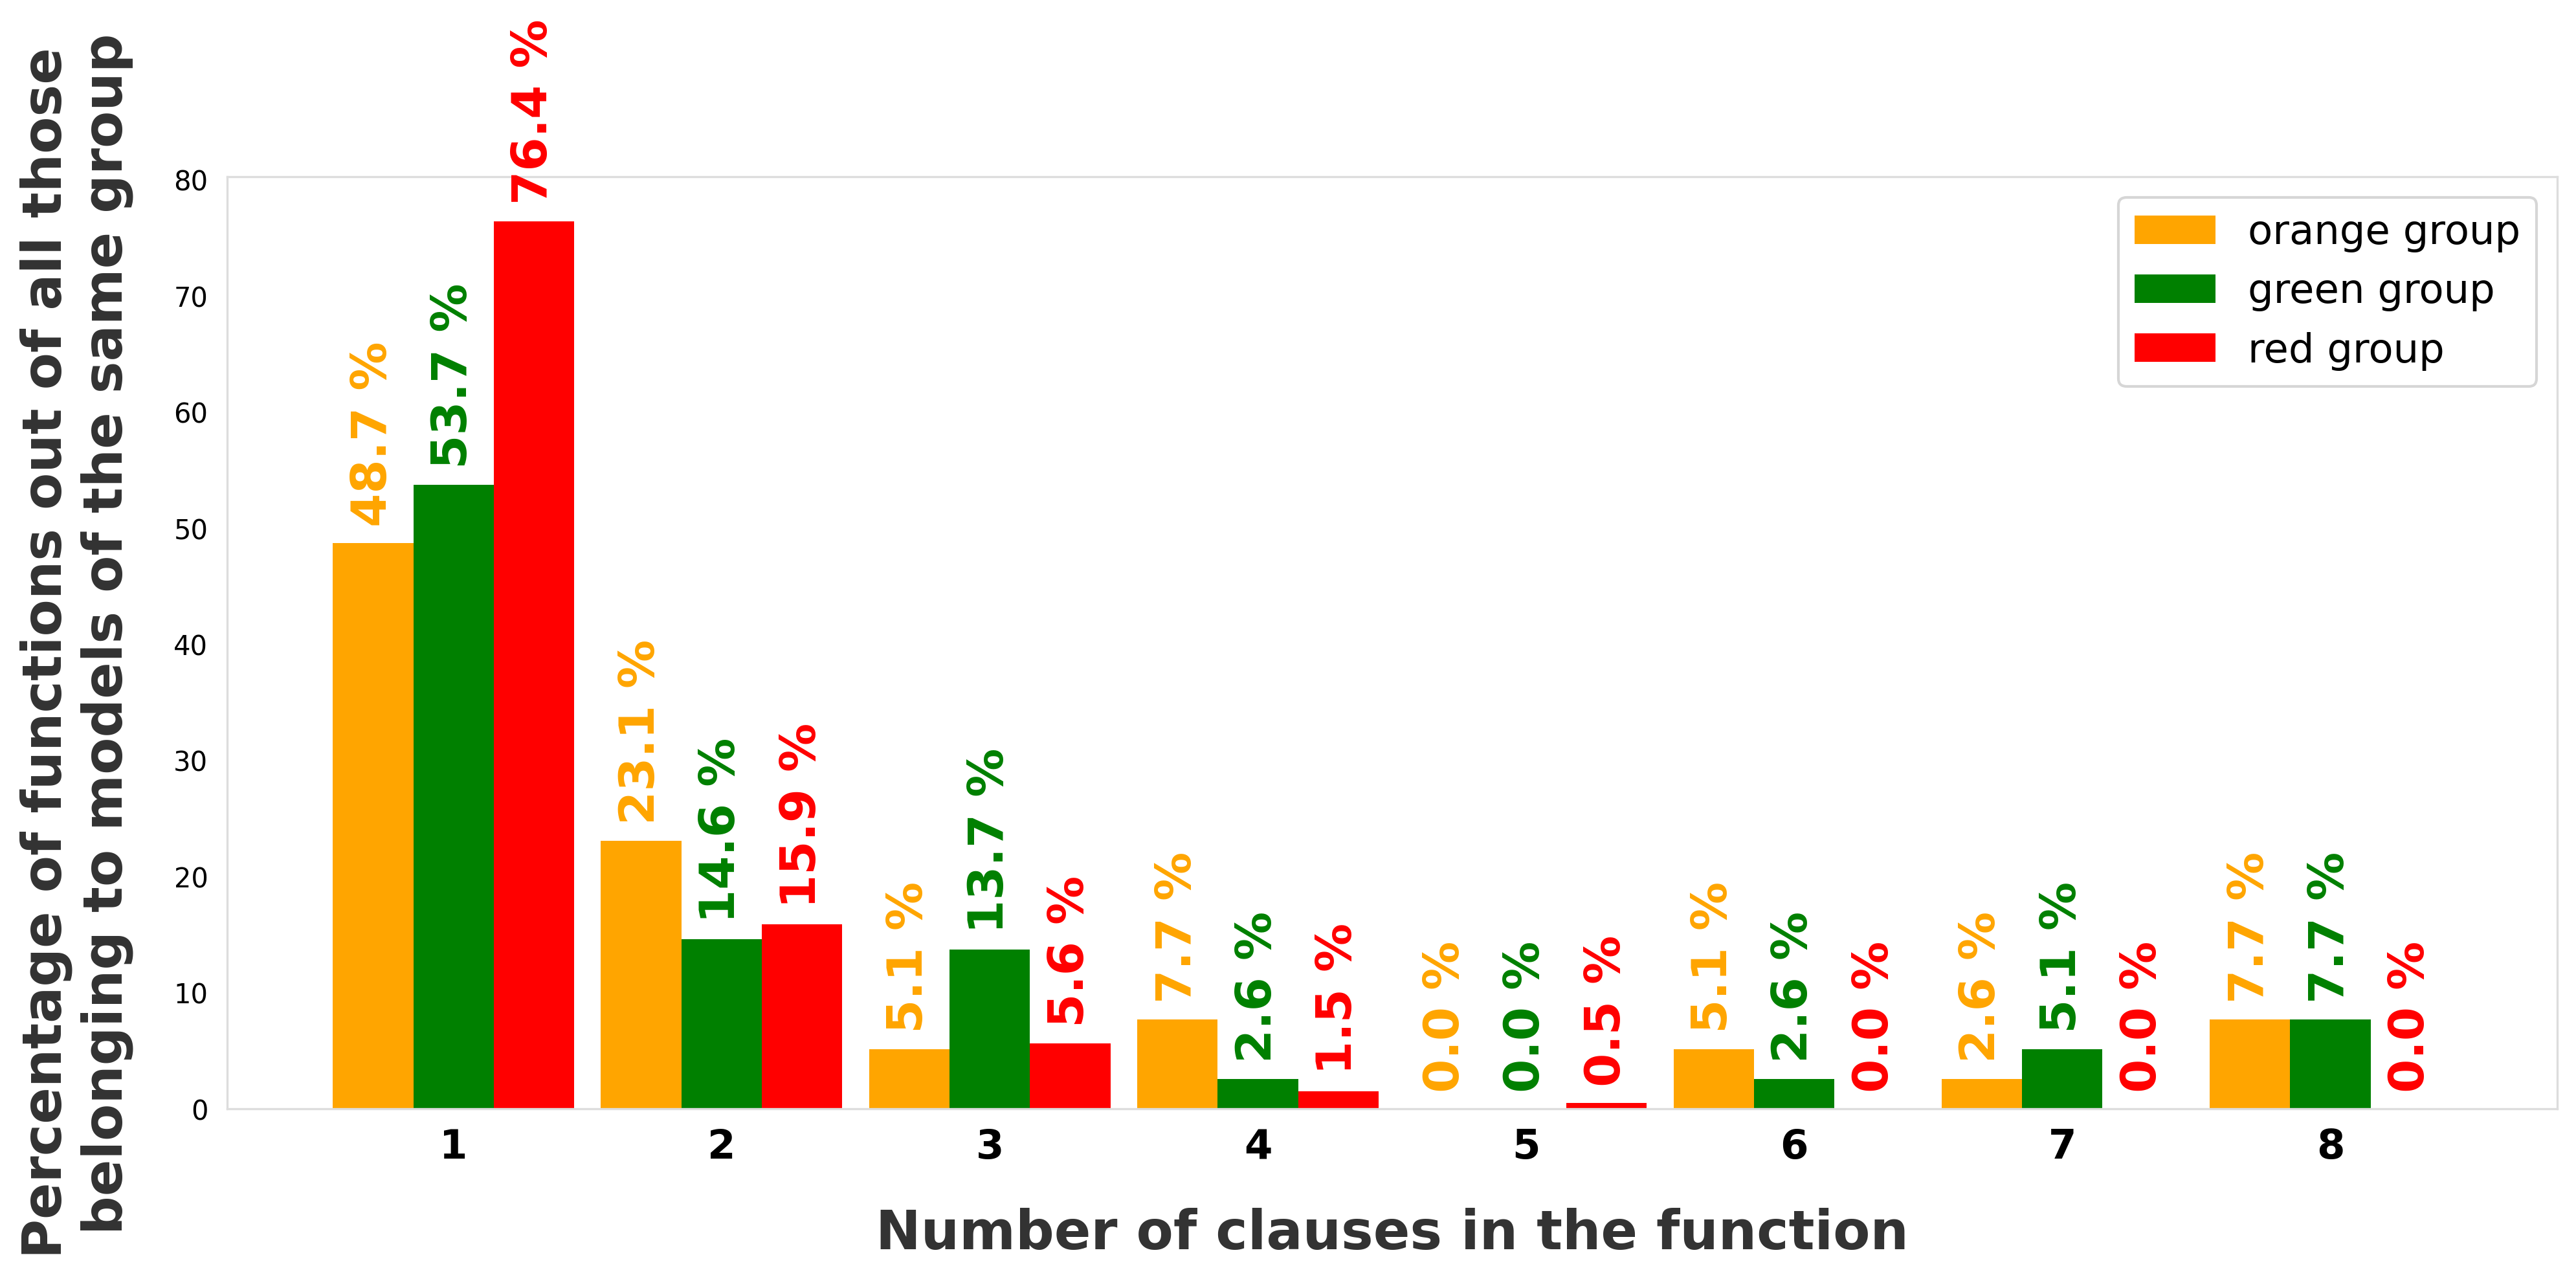

In [42]:
barWidth = 0.3

xsize1 = range(len(nbOfFunctionsPercentage_barplot_orange))
xsize2 = [x + barWidth for x in xsize1]
xsize3 = [x + barWidth for x in xsize2]

y1 = list(nbOfFunctionsPercentage_barplot_red)+[0,0,0]
y2 = nbOfFunctionsPercentage_barplot_orange
y3 = nbOfFunctionsPercentage_barplot_green
label = [i+1 for i in range(len(nbOfFunctionsPercentage_barplot_orange))]

fig = plt.figure(dpi=300)
ax = fig.add_axes([0,0,2,1.2])
bars2 = ax.bar(xsize1, y2, width=barWidth-0.0, color = 'orange', linewidth = 0)
bars3 = ax.bar(xsize2, y3, width = barWidth-0.0, color = 'green', linewidth = 0)
bars1 = ax.bar(xsize3, y1, width = barWidth-0.0, color = 'red', linewidth = 0)

for i,rect in enumerate(bars1):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y1[i]:.1f} %",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='red',
      weight='bold', rotation=90, fontsize=18)

for i,rect in enumerate(bars2):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y2[i]:.1f} %",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='orange',
      weight='bold', rotation=90, fontsize=18)

for i,rect in enumerate(bars3):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y3[i]:.1f} %",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='green',
      weight='bold', rotation=90, fontsize=18)
    
ax.spines['top'].set_color('#DDDDDD')#set_visible(False)
ax.spines['right'].set_color('#DDDDDD')
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_axisbelow(True)
ax.yaxis.grid(False)#(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.tick_params(bottom=False, left=False)

plt.xticks([r + 2*barWidth / 2 for r in xsize1], label, weight='bold', fontsize=15)

plt.legend(["orange group", "green group", "red group"],loc=1, fontsize = 15)

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Number of clauses in the function', labelpad=15, color='#333333', weight='bold', fontsize = 20)
ax.set_ylabel("Percentage of functions out of all those \n belonging to models of the same group", labelpad=15, color='#333333', weight='bold', fontsize = 20)
#ax.set_title('Complexité des fonctions constituant les modèles, selon le groupe.', pad=15, color='#333333', weight='bold')

In [38]:
fig.savefig('data/analysis/clusters/distribution_clauses.png', bbox_inches='tight', dpi=300)

### Complexity of the invariable functions within each cluster? <a class="anchor" id="fctinvcomplexity"></a>

In [39]:
nbOfClausesUniqueFunctionNode_barplot_red, nbOfFunctionsUniqueFunctionNode_percentage_barplot_red, nbOfFunctionsUniqueFunctionNode_barplot_red = create_barplot_vectors_nb_functions_per_nb_clauses(nbOfClausesOfUniqueFunctionNode_red)
nbOfClausesUniqueFunctionNode_barplot_orange, nbOfFunctionsUniqueFunctionNode_percentage_barplot_orange, nbOfFunctionsUniqueFunctionNode_barplot_orange = create_barplot_vectors_nb_functions_per_nb_clauses(nbOfClausesOfUniqueFunctionNode_orange)
nbOfClausesUniqueFunctionNode_barplot_green, nbOfFunctionsUniqueFunctionNode_percentage_barplot_green, nbOfFunctionsUniqueFunctionNode_barplot_green = create_barplot_vectors_nb_functions_per_nb_clauses(nbOfClausesOfUniqueFunctionNode_green)

Text(0, 0.5, 'Percentage of functions out of all \n the invariable ones in the group')

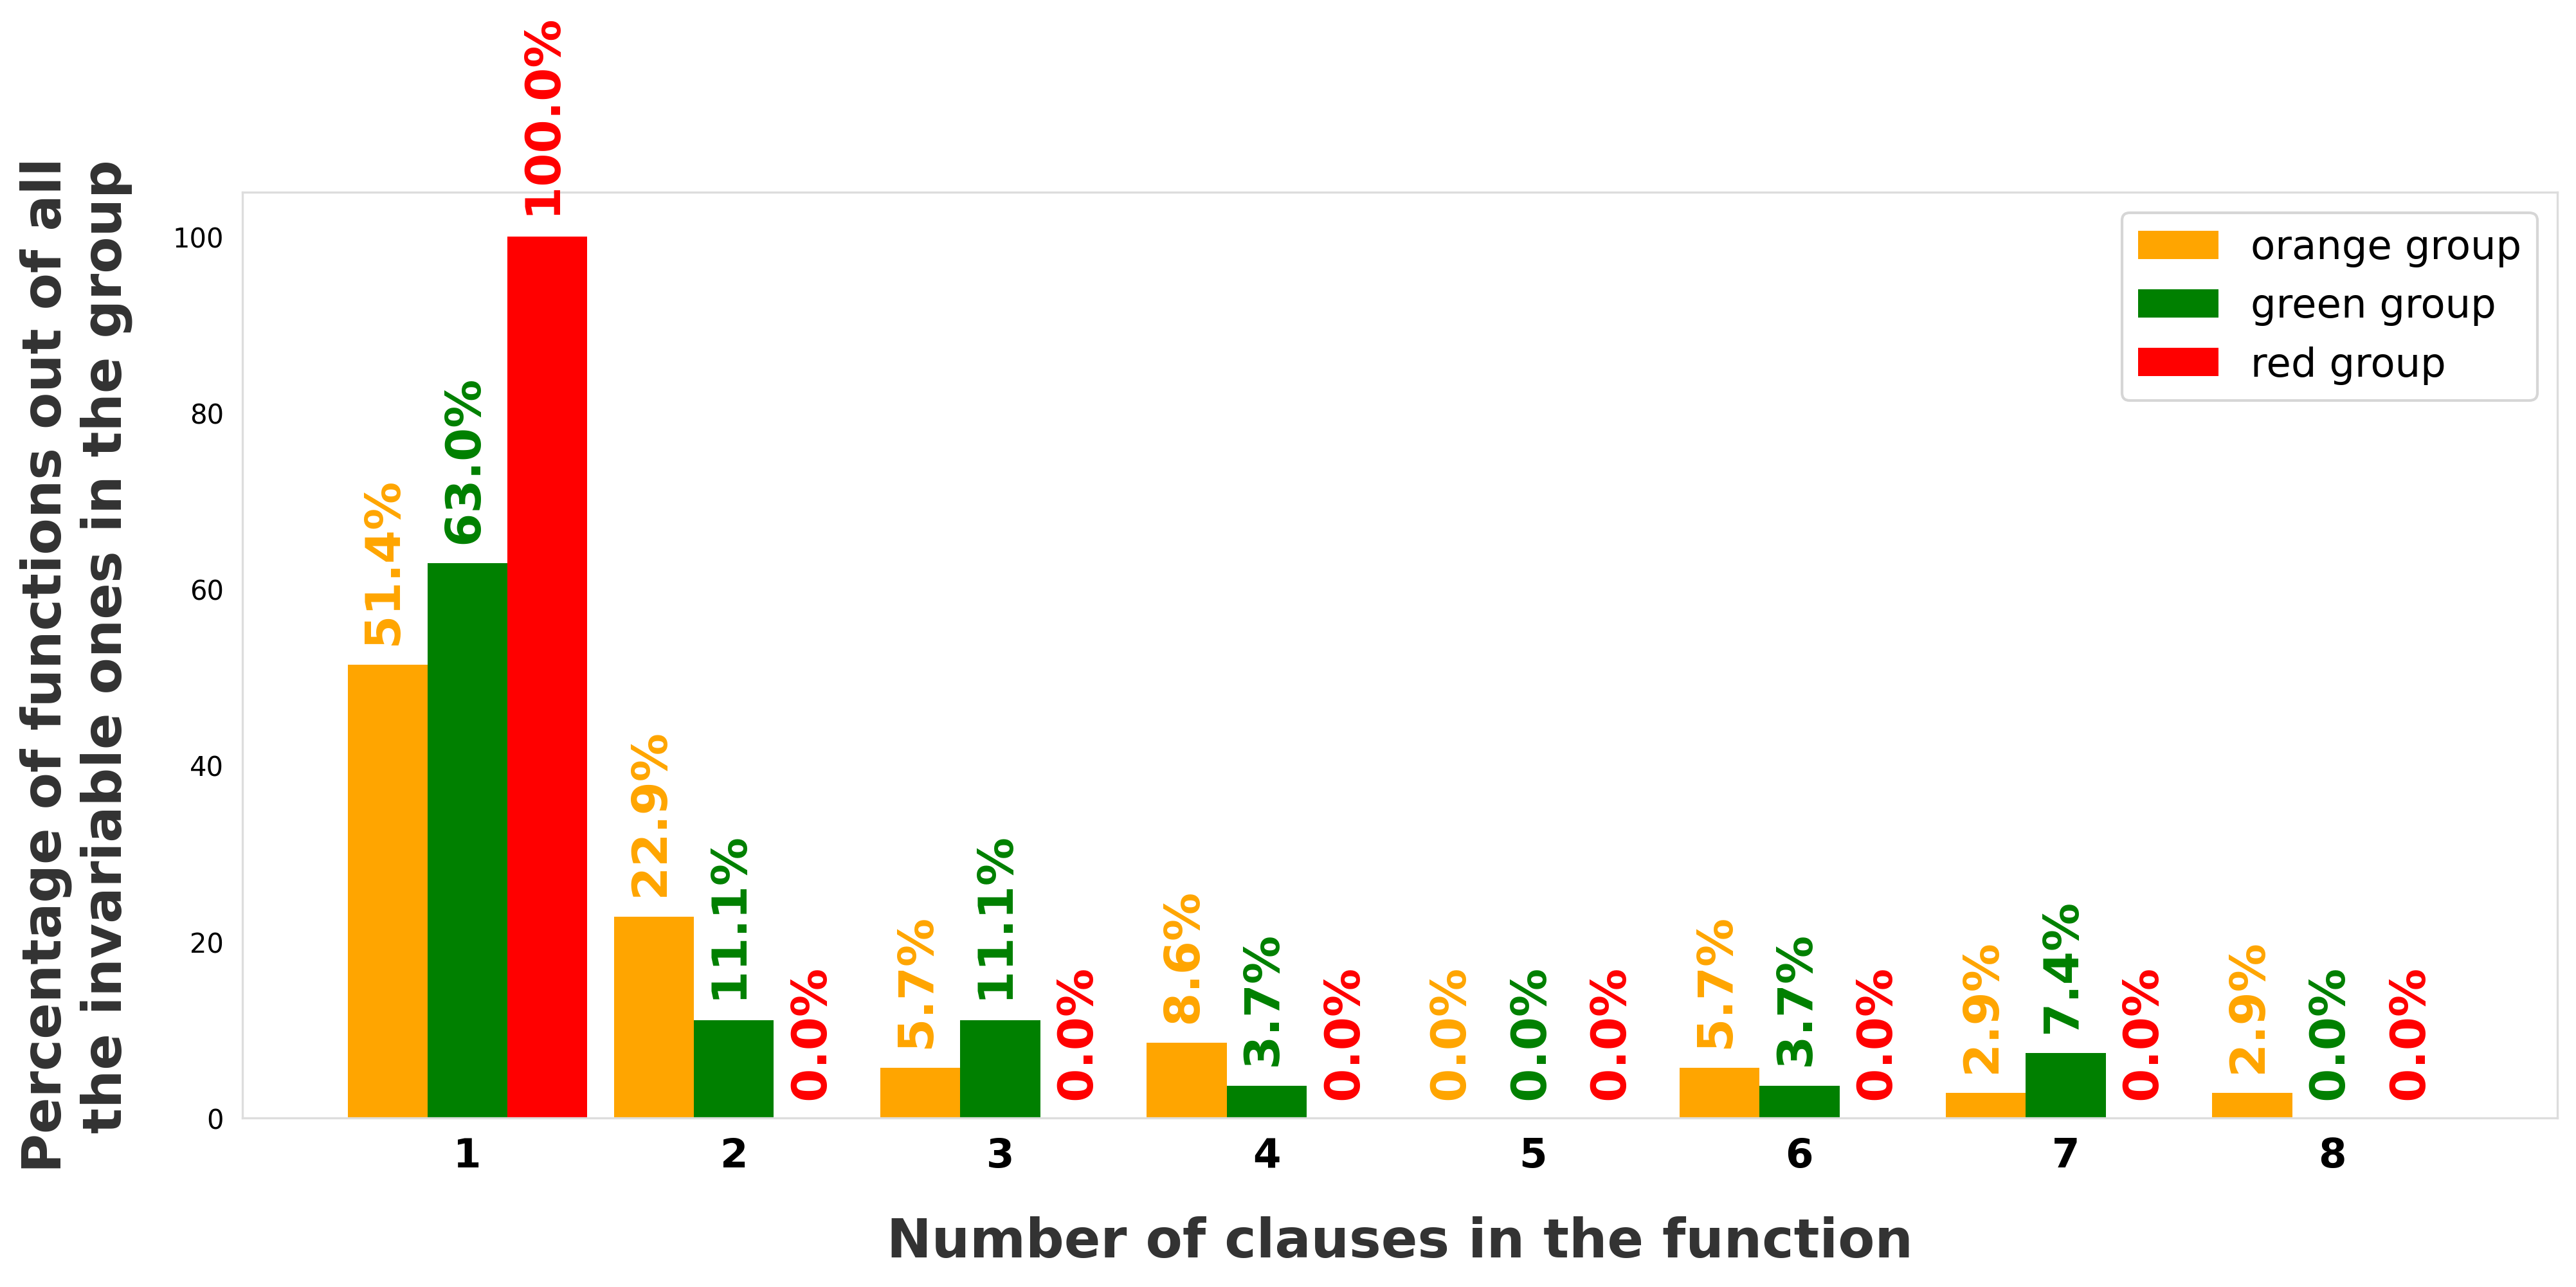

In [43]:
barWidth = 0.3

xsize1 = range(len(nbOfClausesUniqueFunctionNode_barplot_orange))
xsize2 = [x + barWidth for x in xsize1]
xsize3 = [x + barWidth for x in xsize2]

y1 = list(nbOfFunctionsUniqueFunctionNode_percentage_barplot_red) + [0,0,0,0,0,0,0]
y2 = nbOfFunctionsUniqueFunctionNode_percentage_barplot_orange
y3 = list(nbOfFunctionsUniqueFunctionNode_percentage_barplot_green) + [0]
label = [i+1 for i in range(len(nbOfClausesUniqueFunctionNode_barplot_orange))]

fig = plt.figure(dpi=300)
ax = fig.add_axes([0,0,2,1.2])
bars2 = ax.bar(xsize1, y2, width=barWidth, color = 'orange', linewidth = 0)
bars3 = ax.bar(xsize2, y3, width = barWidth, color = 'green', linewidth = 0)
bars1 = ax.bar(xsize3, y1, width = barWidth, color = 'red', linewidth = 0)

for i,rect in enumerate(bars1):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y1[i]:.1f}%",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='red',
      weight='bold', rotation=90, fontsize=18)

for i,rect in enumerate(bars2):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y2[i]:.1f}%",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='orange',
      weight='bold', rotation=90, fontsize=18)

for i,rect in enumerate(bars3):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y3[i]:.1f}%",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='green',
      weight='bold', rotation=90, fontsize=18)
    
ax.spines['top'].set_color('#DDDDDD')#set_visible(False)
ax.spines['right'].set_color('#DDDDDD')
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_axisbelow(True)
ax.yaxis.grid(False)#(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.tick_params(bottom=False, left=False)

plt.xticks([r + 2*barWidth / 2 for r in xsize1], label, weight='bold', fontsize=15)

plt.legend(["orange group", "green group", "red group"],loc=1, fontsize=15)

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Number of clauses in the function', labelpad=15, color='#333333', weight='bold', fontsize = 20)
ax.set_ylabel("Percentage of functions out of all \n the invariable ones in the group", labelpad=15, color='#333333', weight='bold', fontsize = 20)
#ax.set_title('Complexité des fonctions conservées dans les modèles, selon le groupe.', pad=15, color='#333333', weight='bold')

In [44]:
fig.savefig('data/analysis/clusters/distribution_clauses_invariable.png', bbox_inches='tight', dpi=300)

### Complexity of the clauses within the models' functions for each cluster? <a class="anchor" id="clausecomplexity"></a>

In [45]:
def create_barplot_vectors_clause_stat(nbOfComponents):
    vector_components_count = list()
    
    for i in set(nbOfComponents):
        vector_components_count.append(nbOfComponents.count(i))
    
    return np.array(vector_components_count)/sum(vector_components_count)*100

In [46]:
vec_barplot_orange = create_barplot_vectors_clause_stat(nbOfComponentsInClause_orange)
vec_barplot_green = create_barplot_vectors_clause_stat(nbOfComponentsInClause_green)
vec_barplot_red = create_barplot_vectors_clause_stat(nbOfComponentsInClause_red)

Text(0, 0.5, 'Percentage of clauses out of all those belonging \n to the functions of the same group of models')

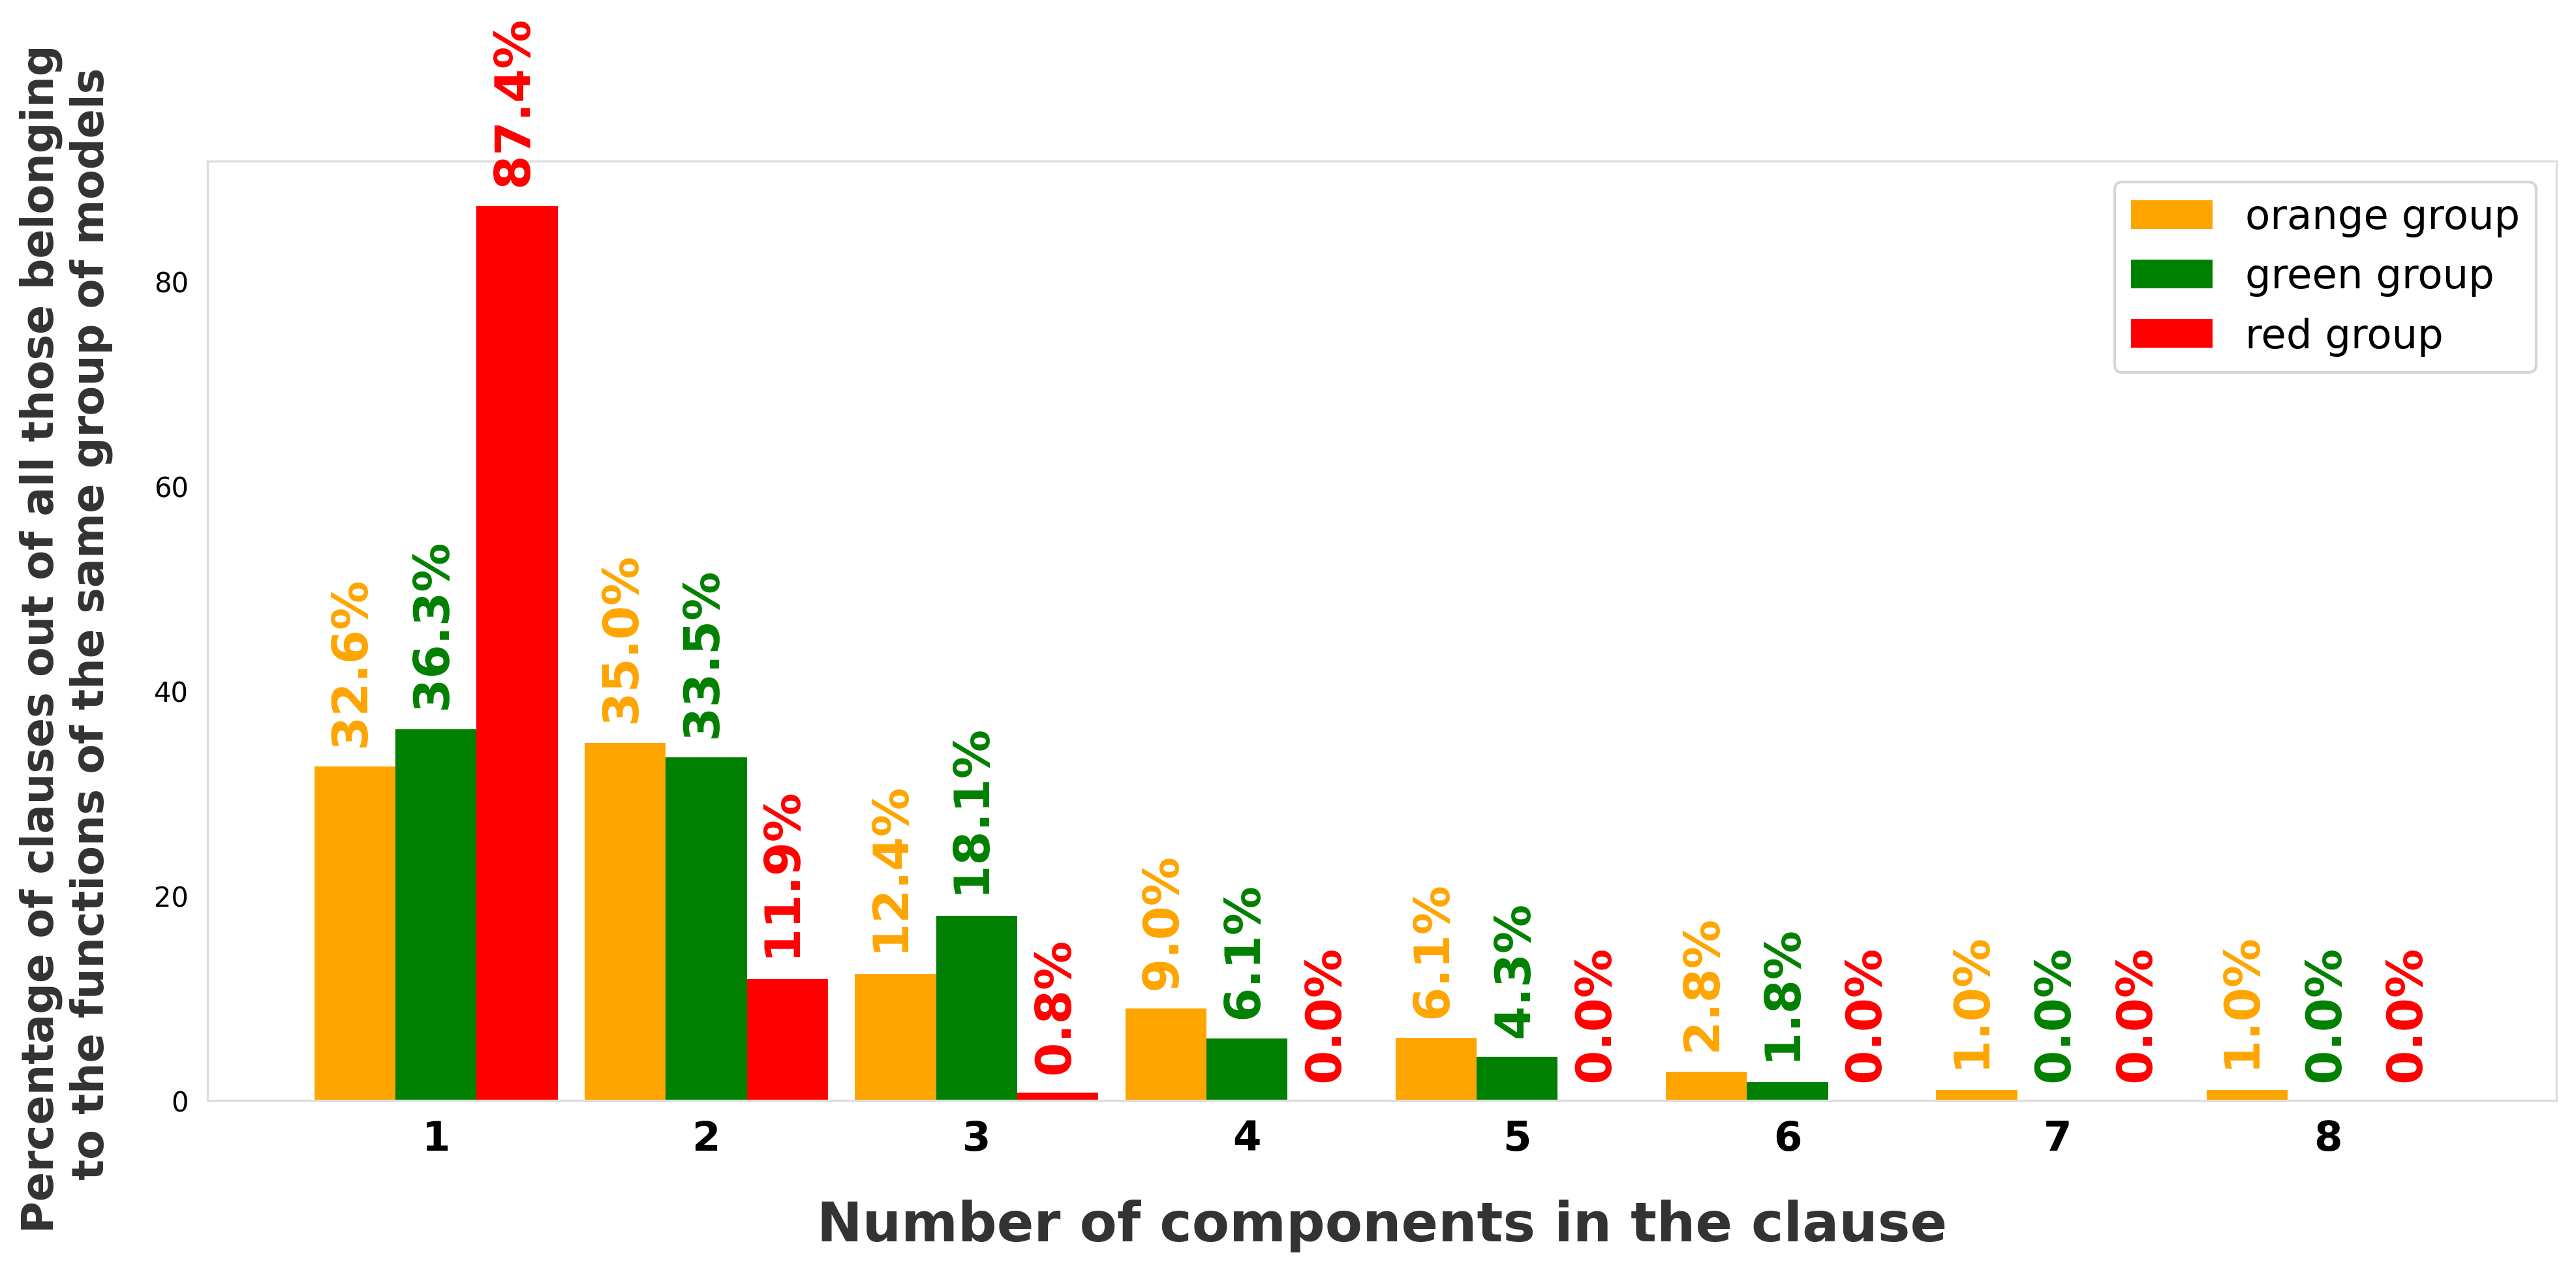

In [50]:
barWidth = 0.3

xsize1 = range(len(vec_barplot_orange))
xsize2 = [x + barWidth for x in xsize1]
xsize3 = [x + barWidth for x in xsize2]

y1 = vec_barplot_orange
y2 = list(vec_barplot_green) + [0,0]
y3 = list(vec_barplot_red) + [0,0,0,0,0]
label = [i+1 for i in range(len(vec_barplot_orange))]

fig = plt.figure(dpi=300)
ax = fig.add_axes([0,0,2,1.2])
bars1 = ax.bar(xsize1, y1, width=barWidth, color = 'orange', linewidth = 0)
bars2 = ax.bar(xsize2, y2, width = barWidth, color = 'green', linewidth = 0)
bars3 = ax.bar(xsize3, y3, width = barWidth, color = 'red', linewidth = 0)

for i,rect in enumerate(bars1):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y1[i]:.1f}%",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='orange',
      weight='bold', rotation=90, fontsize=18)

for i,rect in enumerate(bars2):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y2[i]:.1f}%",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='green',
      weight='bold', rotation=90, fontsize=18)

for i,rect in enumerate(bars3):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f" {y3[i]:.1f}%",
      horizontalalignment='center',
      verticalalignment='bottom',
      color='red',
      weight='bold', rotation=90, fontsize=18)
    
ax.spines['top'].set_color('#DDDDDD')#set_visible(False)
ax.spines['right'].set_color('#DDDDDD')
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')

ax.set_axisbelow(True)
ax.yaxis.grid(False)#(True, color='#EEEEEE')
ax.xaxis.grid(False)

ax.tick_params(bottom=False, left=False)

plt.xticks([r + 2*barWidth / 2 for r in xsize1], label, weight='bold', fontsize=15)

plt.legend(["orange group", "green group", "red group"],loc=1, fontsize=15)

# Add labels and a title. Note the use of `labelpad` and `pad` to add some
# extra space between the text and the tick labels.
ax.set_xlabel('Number of components in the clause', labelpad=15, color='#333333', weight='bold', fontsize = 20)
ax.set_ylabel("Percentage of clauses out of all those belonging \n to the functions of the same group of models", labelpad=15, color='#333333', weight='bold', fontsize = 16)
#ax.set_title('Complexité des clauses constituant les fonctions des modèles, selon le groupe.', pad=15, color='#333333', weight='bold')

In [51]:
fig.savefig('data/analysis/clusters/distribution_components.png', bbox_inches='tight', dpi=300)

### Statistics on each cluster: <a class="anchor" id="stat"></a>

In [55]:
def stat_cluster(cluster: list):

    nb_clauses_dans_fonction = list()
    nb_composants_dans_clause = list()

    for bn in cluster:
        for gene in clauses_per_model[bn].keys():
            fonction = clauses_per_model[bn][gene]
            if fonction == True or fonction == False:
                nb_clauses_dans_fonction.append(1)
                nb_composants_dans_clause.append(1)
            else:
                nb_clauses_dans_fonction.append(len(fonction))
                for clause in fonction:
                    nb_composants_dans_clause.append(len(clause))
                    
    nb_clauses_dans_fonction_np = np.array(nb_clauses_dans_fonction)
    nb_composants_dans_clause_np = np.array(nb_composants_dans_clause)
    
    print(f"{len(cluster)} modèles\n")
    
    print("Statistique sur le nombre de clauses par fonction :")
    print(f" - {nb_clauses_dans_fonction.count(1)/len(nb_clauses_dans_fonction):.2%} des fonctions ont une seule clause")
    print(f" - nombre moyen de clauses par fonction: {nb_clauses_dans_fonction_np.mean():.2f}")
    print(f" - médiane du nombre de clauses par fonction: {np.median(nb_clauses_dans_fonction_np):.2f}")
    print(f" - min et max du nombre de clauses par fonction: {np.min(nb_clauses_dans_fonction_np):.2f}, {np.max(nb_clauses_dans_fonction_np):.2f}\n")
    
    print("Statistique sur le nombre de composants par clause :")
    print(f" - {nb_composants_dans_clause.count(1)/len(nb_composants_dans_clause):.2%} des clauses n'ont qu'un seul composant")
    print(f" - nombre moyen de composants par clause: {nb_composants_dans_clause_np.mean():.2f}")
    print(f" - médiane du nombre de composants par fonction: {np.median(nb_composants_dans_clause_np):.2f}")
    print(f" - min et max du nombre de clauses par fonction: {np.min(nb_composants_dans_clause_np):.2f}, {np.max(nb_composants_dans_clause_np):.2f}\n")
    
    return nb_clauses_dans_fonction_np, nb_composants_dans_clause_np

In [56]:
print("Red cluster:")
(clauses_rouge, composants_rouge) = stat_cluster(cluster_red)

Red cluster:
5 modèles

Statistique sur le nombre de clauses par fonction :
 - 76.41% des fonctions ont une seule clause
 - nombre moyen de clauses par fonction: 1.34
 - médiane du nombre de clauses par fonction: 1.00
 - min et max du nombre de clauses par fonction: 1.00, 5.00

Statistique sur le nombre de composants par clause :
 - 87.36% des clauses n'ont qu'un seul composant
 - nombre moyen de composants par clause: 1.13
 - médiane du nombre de composants par fonction: 1.00
 - min et max du nombre de clauses par fonction: 1.00, 3.00



In [58]:
print("Orange cluster:")
(clauses_orange, composants_orange) = stat_cluster(cluster_orange)

Orange cluster:
885 modèles

Statistique sur le nombre de clauses par fonction :
 - 48.72% des fonctions ont une seule clause
 - nombre moyen de clauses par fonction: 2.51
 - médiane du nombre de clauses par fonction: 2.00
 - min et max du nombre de clauses par fonction: 1.00, 8.00

Statistique sur le nombre de composants par clause :
 - 32.63% des clauses n'ont qu'un seul composant
 - nombre moyen de composants par clause: 2.39
 - médiane du nombre de composants par fonction: 2.00
 - min et max du nombre de clauses par fonction: 1.00, 8.00



In [59]:
print("Green cluster:")
(clauses_vert, composants_vert) = stat_cluster(cluster_green)

Green cluster:
110 modèles

Statistique sur le nombre de clauses par fonction :
 - 53.73% des fonctions ont une seule clause
 - nombre moyen de clauses par fonction: 2.47
 - médiane du nombre de clauses par fonction: 1.00
 - min et max du nombre de clauses par fonction: 1.00, 8.00

Statistique sur le nombre de composants par clause :
 - 36.28% des clauses n'ont qu'un seul composant
 - nombre moyen de composants par clause: 2.14
 - médiane du nombre de composants par fonction: 2.00
 - min et max du nombre de clauses par fonction: 1.00, 6.00



#### To go deeper into the details for each cluster, creation of 3 files (red_comparison.txt, orange_comparison.txt, green_comparison.txt) containing statistics "intra" clusters:

In [30]:
def common_and_distinct_functions(influences, clauses_per_model, cluster_indices):
    clauses_en_commun = clauses_per_model[cluster_indices[0]].copy()
    fonctions_differentes = dict()
    
    for node in influences.keys():
        if node not in fonctions_differentes:
            fonctions_differentes[node] = set()
            fonctions_differentes[node].add(clauses_per_model[cluster_indices[0]][node])
        for indice in cluster_indices:
            if clauses_per_model[indice][node] != fonctions_differentes[node]:
                fonctions_differentes[node].add(clauses_per_model[indice][node])
            if node in clauses_en_commun:
                if clauses_per_model[indice][node] != clauses_en_commun[node]:
                    del clauses_en_commun[node]
    
    clauses = clauses_per_model[cluster_indices[0]].copy()
    for node in clauses_en_commun.keys():
        del clauses[node]
    
    clauses_differentes = (clauses.keys(), fonctions_differentes)
    
    return clauses_en_commun, clauses_differentes

In [55]:
def intra_cluster_comparison(cluster_id, clauses, cluster_indices, flag: bool = True):
    flag_text = "identical" if flag else "different"

    with open(f"data/analysis/clusters/{cluster_id}_comparison.txt", "w") as f:
        f.write(f"{len(clauses[0])} nodes have {flag_text} fonctions among {len(cluster_indices)} BNs : {list(clauses[0])}\n")
    
        for node in clauses[0]:
            f.write(f"\n--- {node:<7} : {len(clauses[1][node])} different fonctions:\n")
            for fonction in clauses[1][node]:
                f.write(f" >> {fonction}\n")

In [56]:
clauses_en_commun_cluster0, clauses_distinctes_cluster0 = common_and_distinct_functions(influences, clauses_per_model, cluster0_indices)
clauses_en_commun_cluster1, clauses_distinctes_cluster1 = common_and_distinct_functions(influences, clauses_per_model, cluster1_indices)
clauses_en_commun_cluster2, clauses_distinctes_cluster2 = common_and_distinct_functions(influences, clauses_per_model, cluster2_indices)

In [57]:
intra_cluster_comparison("red", clauses_distinctes_cluster0, cluster0_indices, flag=False)

In [58]:
intra_cluster_comparison("orange", clauses_distinctes_cluster1, cluster1_indices, flag=False)

In [59]:
intra_cluster_comparison("green", clauses_distinctes_cluster2, cluster2_indices, flag=False)